In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

#### Import niezbędnych bibliotek.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, OneHotEncoder
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### Załadowanie danych

In [0]:
df = spark.read.csv('/FileStore/tables/dyp/dane_end3.csv',inferSchema=True,header=True,sep=";")

In [0]:
df.printSchema()

root
 |-- NR_PRAC: string (nullable = true)
 |-- PESEL_ANO: decimal(22,0) (nullable = true)
 |-- WIEK: integer (nullable = true)
 |-- WYK: string (nullable = true)
 |-- PLEC: string (nullable = true)
 |-- MZ_ANO: string (nullable = true)
 |-- KOD: string (nullable = true)
 |-- WOJE: string (nullable = true)
 |-- UMOCZAS: string (nullable = true)
 |-- CZASO: string (nullable = true)
 |-- UMSTART: timestamp (nullable = true)
 |-- UMSTOP: timestamp (nullable = true)
 |-- M3: integer (nullable = true)
 |-- STANSYM: integer (nullable = true)
 |-- GRUZAW: integer (nullable = true)
 |-- PGRUZAW: integer (nullable = true)
 |-- ZATRODZ: string (nullable = true)
 |-- ETAT: string (nullable = true)
 |-- MPK: string (nullable = true)
 |-- WYNAGR: string (nullable = true)
 |-- JEDN: string (nullable = true)



In [0]:
print("Liczba rekordów do analizy: ",df.count())

Liczba rekordów do analizy:  63666


#### Sprawdzenie i usunięcie duplikatów wg. pola `PESEL_ANO`

Ponieważ określona osoba może być zatrudniania wielokrotnie a z wywiadu z pracownikami Firmy wynika, że w takich przypadkach w większości są to umowy na okres krótszy niż 3 miesiące i zawierane w celu czasowego zapotrzebowania na pracowników (sezonowość), to zdecydowano o usunięciu tego typu rekordów z dalszej analizy.

In [0]:
df_duplikat = df.join(
    df.groupBy('PESEL_ANO').agg((count("*")>1).cast("int").alias("Duplikat")),
    on='PESEL_ANO',
    how="inner"
)
df_nodup = df_duplikat.filter(df_duplikat['Duplikat'] == 0)
print("Liczba rekordów po usunięciu duplikatów: ",df_nodup.count())
df = df_nodup

Liczba rekordów po usunięciu duplikatów:  52890


In [0]:
df_duplikat.select('PESEL_ANO', 'Duplikat').show(4)

+--------------------+--------+
|           PESEL_ANO|Duplikat|
+--------------------+--------+
|88800008144807567...|       0|
|77100008073607247...|       0|
|99600916071200723...|       0|
|55600040070000166...|       0|
+--------------------+--------+
only showing top 4 rows



#### Wybór zmiennych do analizy na podstawie wiedzy eksperckiej

Część z dostarczonych przez Firmę danych nie wnosi wartości dodanej do dalszej analizy i z tego względu dane te zostaną usuniete z df.

In [0]:
df.columns

Out[7]: ['PESEL_ANO',
 'NR_PRAC',
 'WIEK',
 'WYK',
 'PLEC',
 'MZ_ANO',
 'KOD',
 'WOJE',
 'UMOCZAS',
 'CZASO',
 'UMSTART',
 'UMSTOP',
 'M3',
 'STANSYM',
 'GRUZAW',
 'PGRUZAW',
 'ZATRODZ',
 'ETAT',
 'MPK',
 'WYNAGR',
 'JEDN',
 'Duplikat']

In [0]:
df = df.select('WIEK', 'WYK', 'PLEC', 'WOJE', 'UMOCZAS', 'JEDN', 'GRUZAW', 'PGRUZAW', 'ZATRODZ', 'ETAT' ,'WYNAGR','M3')
#df.limit(5).toPandas()

In [0]:
df.summary().display()

summary,WIEK,WYK,PLEC,WOJE,UMOCZAS,JEDN,GRUZAW,PGRUZAW,ZATRODZ,ETAT,WYNAGR,M3
count,52890,52890,52890,52451,52889,52890,52890,52890,52890,52890,52890,52890
mean,35.128417470221216,null,null,null,null,null,12.722953299300436,1.4324068822083569,null,1.0,null,0.33499716392512763
stddev,11.721630395051536,null,null,null,null,null,2.95586803325751,1.0699667655701925,null,0.0,null,0.4719939366062421
min,18,gimnazjalne,K,dolnośląskie,czas nieokreślony,jed1,2,0,dodatkowe zatrudnienie emeryta/rencisty,"0,05",Grade01,0
25%,25,null,null,null,null,null,12,1,null,1.0,null,0
50%,33,null,null,null,null,null,14,1,null,1.0,null,0
75%,43,null,null,null,null,null,14,2,null,1.0,null,1
max,77,średnie techniczne,M,świętokrzyskie,zastępstwo za pracownika przebywającego na zwolnieniu lekarskim,jed9,19,8,główne zatrudnienie emeryta/rencisty,1,Grade49,1


#### Sprawdzenie wartości NaN i Null

In [0]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0------
 WIEK    | 0   
 WYK     | 0   
 PLEC    | 0   
 WOJE    | 0   
 UMOCZAS | 0   
 JEDN    | 0   
 GRUZAW  | 0   
 PGRUZAW | 0   
 ZATRODZ | 0   
 ETAT    | 0   
 WYNAGR  | 0   
 M3      | 0   

None


In [0]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0------
 WIEK    | 0   
 WYK     | 0   
 PLEC    | 0   
 WOJE    | 439 
 UMOCZAS | 1   
 JEDN    | 0   
 GRUZAW  | 0   
 PGRUZAW | 0   
 ZATRODZ | 0   
 ETAT    | 0   
 WYNAGR  | 0   
 M3      | 0   



Wartości `null` wystąpiły w zmiennych "WOJE" i "UMOCZAS". Ze względu na brak możliwości uzupełnienia ww. braków innymi wartościami w sposób zapewniający logiczną spójność z pozostałymi wartościami zmiennej, zdecydowano o usunięciu rekordów z brakami z dalszej analizy.

In [0]:
df_nonull = df.filter(df['WOJE'].isNotNull())
print("Liczba rekordów po usunięciu wrtości 'null': ",df_nonull.count())

Liczba rekordów po usunięciu wrtości 'null':  52451


In [0]:
df_nonull.select([count(when(col(c).isNull(), c)).alias(c) for c in df_nonull.columns]).display()

WIEK,WYK,PLEC,WOJE,UMOCZAS,JEDN,GRUZAW,PGRUZAW,ZATRODZ,ETAT,WYNAGR,M3
0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
print("Liczba rekordów po usunięciu wrtości 'null': ",df_nonull.count())

Liczba rekordów po usunięciu wrtości 'null':  52451


In [0]:
df = df_nonull

#### Elementy EDA

In [0]:
df.groupBy('WOJE').count().orderBy('count', ascending=False).display()

WOJE,count
mazowieckie,8085
śląskie,5961
wielkopolskie,4897
dolnośląskie,4528
zachodniopomorskie,3820
pomorskie,3706
małopolskie,3620
łódzkie,3179
kujawsko-pomorskie,2567
lubelskie,2339


W badanym okresie najliczniejszymi, zatrudnianymi grupami pracowników były osoby zamieszkujące województwa: mazowieckie, śląskie, wielkopolskie i dolnośląskie.

In [0]:
spark.read.csv('/FileStore/tables/dyp/dane_end3.csv',inferSchema=True,header=True,sep=";").select('MZ_ANO')\
.groupBy('MZ_ANO').count().orderBy('count', ascending=False).limit(30).display()
#df.groupBy('MZ_ANO').count().orderBy('count', ascending=False).limit(30).display()

MZ_ANO,count
m9137,4036
m8425,1517
m9725,1355
m3714,1196
m4539,1190
m1922,921
m853,717
m9865,681
m4294,646
m301,525


Najwięcej pracowników pochodziło z miejscowości m9137.

In [0]:
import seaborn as sns

In [0]:
df1 = spark.read.csv('/FileStore/tables/dyp/dane_end3.csv',inferSchema=True,header=True,sep=";")
df1 = df1.drop('PESEL_ANO')
df_pandas = df1.toPandas()

In [0]:
df1.select('WIEK').display()

WIEK
20
26
42
50
25
39
27
64
48
25


Out[60]: <AxesSubplot:>

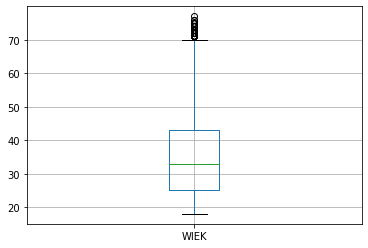

In [0]:
df_pandas.boxplot('WIEK')

In [0]:
df1.select('WIEK').describe().show()

+-------+------------------+
|summary|              WIEK|
+-------+------------------+
|  count|             63666|
|   mean| 35.00882731756354|
| stddev|11.708898171059163|
|    min|                18|
|    max|                77|
+-------+------------------+



Out[63]: <AxesSubplot:xlabel='WIEK'>

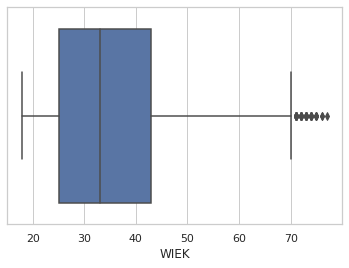

In [0]:
sns.set_theme(style="whitegrid")
sns.boxplot(x="WIEK", data=df_pandas)

Średnia wieku pracowników zatrudnianych w badanym okresie wynosiła 35 lat, przy czym najmłodsza osoba miała 18 lat a najstarsza 77. Z uwagi na sędziwy wiek najstarszego pracownika, zasadna jest weryfikacja, czy nie jest to wartość błędna. Potwierdza to również wykres pudelkowy, na którym widać wartości odstające.

In [0]:
df.select('WIEK').filter(df['WIEK']>65).count()

Out[65]: <AxesSubplot:xlabel='WIEK', ylabel='PLEC'>

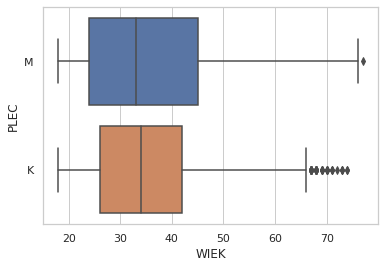

In [0]:
sns.set_theme(style="whitegrid")
sns.boxplot(x="WIEK", y="PLEC", data=df_pandas)

In [0]:
#df1.select('GRUZAW').agg(min('GRUZAW'),max('GRUZAW')).show()
df1.select('GRUZAW').groupBy('GRUZAW').count().count()

Out[73]: 14

In [0]:
df1.select('M3','GRUZAW').filter(df['M3'] == 1).groupBy('GRUZAW').count().orderBy('count',ascending=False).display()

GRUZAW,count
14,9579
8,3530
13,2404
15,1029
17,601
16,190
18,134
12,39
4,10
9,9


Spośród osób, które pracowały krócej niż 3 miesiące (M3=1) najwięcej było osób z grup zawodowych o numerach 14, 8 i 13.

In [0]:
df_pandas.columns

In [0]:
df1.select('PLEC').groupBy('PLEC').count().display()

PLEC,count
K,35327
M,28339


W badanym okresie zatrudnianych było więcej kobiet niż mężczyzn.

In [0]:
df1.select('M3','PLEC').display()

M3,PLEC
0,M
0,M
0,M
0,K
0,M
0,M
1,M
0,M
1,K
0,M


Wśród grupy osób, które przepracowały więcej niż 3 miesiące (M3=0), większość stanowiły kobiety. Wśród grupy osób, które przepracowały mniej niż 3 miesiące (M3=1), większość stanowili mężczyźni.

In [0]:
df1.select('WYNAGR').display()

WYNAGR
Grade08
Grade09
Grade36
Grade01
Grade09
Grade09
Grade15
Grade16
Grade17
Grade09


In [0]:
df1.groupBy('WYNAGR').count().orderBy('count', ascending=False).display()

WYNAGR,count
Grade05,15641
Grade03,10960
Grade07,7785
Grade04,7035
Grade06,6527
Grade09,4207
Grade01,4065
Grade02,3438
Grade13,771
Grade08,497


In [0]:
df1.select('M3', 'WYNAGR').display()

M3,WYNAGR
0,Grade08
0,Grade09
0,Grade36
0,Grade01
0,Grade09
0,Grade09
1,Grade15
0,Grade16
1,Grade17
0,Grade09


Wśród grupy osób, które przepracowały mniej niż 3 miesiące (M3=1), większość było osób z wynagrodzeniem z zakresu od Grade01 do Grade09 a najwięcej z Grade05.

In [0]:
grade_m3_1 = df1.select('M3','WYNAGR').filter(df1['M3']==1).groupBy('WYNAGR').count().orderBy('count',ascending=False)
grade_m3_1 = grade_m3_1.withColumnRenamed('count','count_1')

In [0]:
grade_m3_1.show()

+-------+-------+
| WYNAGR|count_1|
+-------+-------+
|Grade05|   5251|
|Grade03|   4074|
|Grade07|   2633|
|Grade04|   2557|
|Grade06|   2077|
|Grade01|   1473|
|Grade09|   1125|
|Grade02|   1124|
|Grade13|    169|
|Grade08|     89|
|Grade16|     86|
|Grade11|     51|
|Grade10|     44|
|Grade14|     44|
|Grade12|     32|
|Grade15|     19|
|Grade18|     14|
|Grade17|     14|
|Grade19|      9|
|Grade31|      8|
+-------+-------+
only showing top 20 rows



In [0]:
grade_m3_all = df1.groupBy('WYNAGR').count().orderBy('count', ascending=False)

In [0]:
grade_out_ratio = grade_m3_all.join(grade_m3_1, on='WYNAGR')

In [0]:
grade_out_ratio.withColumn('out_ratio', grade_out_ratio['count_1']/grade_out_ratio['count']*100).orderBy('out_ratio', ascending=False).select('WYNAGR','out_ratio').display()

WYNAGR,out_ratio
Grade03,37.17153284671533
Grade04,36.34683724235963
Grade01,36.23616236162361
Grade07,33.82145150931278
Grade05,33.5720222492168
Grade02,32.69342641070389
Grade06,31.82166385782136
Grade38,27.27272727272727
Grade16,26.959247648902824
Grade09,26.741145709531732


Największy wskaźnik rezygnacji w ciągu 3 pierwszych miesięcy od przyjęcia do pracy występuję w grupie osób zatrudnionych z wynagrodzeniem Grade03, tj. 37,23%.

#### Kategoryzacja zmiennych

Algorytmy biblioteki MLlib wymagaja określonej struktury danych wsadowych do przetwarzania. W związku z tym zmienne objaśniające typu dyskretnego (opisowe) należy odpowiednio przetworzyć i zmienić na wartości numeryczne. Zmienne typu ciagłego na tym etapie pozostaja bez zmian.

In [0]:
df.printSchema()

root
 |-- WIEK: integer (nullable = true)
 |-- WYK: string (nullable = true)
 |-- PLEC: string (nullable = true)
 |-- WOJE: string (nullable = true)
 |-- UMOCZAS: string (nullable = true)
 |-- JEDN: string (nullable = true)
 |-- GRUZAW: integer (nullable = true)
 |-- PGRUZAW: integer (nullable = true)
 |-- ZATRODZ: string (nullable = true)
 |-- ETAT: string (nullable = true)
 |-- WYNAGR: string (nullable = true)
 |-- M3: integer (nullable = true)



In [0]:
df_ml = df 

In [0]:
# mimo, że zmienne 'GRUZAW' i 'PGRUZAW' maja postać numeryczną i wyglądają na ciągłe, to tak naprawdę sa zmiennymi dykretnymi, gdzie numery sa nazwami klas przyporządkowania

In [0]:
df_ml = df_ml.withColumn('GRUZAW', df_ml['GRUZAW'].cast(StringType()))
df_ml = df_ml.withColumn('PGRUZAW', df_ml['PGRUZAW'].cast(StringType()))

In [0]:
df_ml.printSchema()

root
 |-- WIEK: integer (nullable = true)
 |-- WYK: string (nullable = true)
 |-- PLEC: string (nullable = true)
 |-- WOJE: string (nullable = true)
 |-- UMOCZAS: string (nullable = true)
 |-- JEDN: string (nullable = true)
 |-- GRUZAW: string (nullable = true)
 |-- PGRUZAW: string (nullable = true)
 |-- ZATRODZ: string (nullable = true)
 |-- ETAT: string (nullable = true)
 |-- WYNAGR: string (nullable = true)
 |-- M3: integer (nullable = true)



Zmienne objaśniające ostatecznie przybierają postać wektora nazywanego `features`  a zmienna objaśnia to wektor `label`.

In [0]:
# input_columns -  lista kolumn do utworzenia zmiennej `features`
drop_col = 'M3' 
input_columns = df_ml.select([cols for cols in df_ml.columns if cols not in drop_col]).columns
input_columns

Out[11]: ['WIEK',
 'WYK',
 'PLEC',
 'WOJE',
 'UMOCZAS',
 'JEDN',
 'GRUZAW',
 'PGRUZAW',
 'ZATRODZ',
 'ETAT',
 'WYNAGR']

In [0]:
# indexed - robocza DataFrame, w której utworzone zostaną zmienne `features` i `label`

indexed = df_ml.withColumn('label',df_ml['M3'])

In [0]:
indexed.printSchema()

root
 |-- WIEK: integer (nullable = true)
 |-- WYK: string (nullable = true)
 |-- PLEC: string (nullable = true)
 |-- WOJE: string (nullable = true)
 |-- UMOCZAS: string (nullable = true)
 |-- JEDN: string (nullable = true)
 |-- GRUZAW: string (nullable = true)
 |-- PGRUZAW: string (nullable = true)
 |-- ZATRODZ: string (nullable = true)
 |-- ETAT: string (nullable = true)
 |-- WYNAGR: string (nullable = true)
 |-- M3: integer (nullable = true)
 |-- label: integer (nullable = true)



In [0]:
print(input_columns)

['WIEK', 'WYK', 'PLEC', 'WOJE', 'UMOCZAS', 'JEDN', 'GRUZAW', 'PGRUZAW', 'ZATRODZ', 'ETAT', 'WYNAGR']


Zamiana typu z opisowego na numeryczny dla zmiennych kategorialnych.

In [0]:
numeric_inputs = []
string_inputs = []
for column in input_columns:
    if str(indexed.schema[column].dataType) == 'StringType':
        indexer = StringIndexer(inputCol=column, outputCol=column+"_num")
        encoder = OneHotEncoder(inputCol=column+"_num", outputCol=column+"_vec")
        indexed = indexer.fit(indexed).transform(indexed)
        indexed = encoder.fit(indexed).transform(indexed)
        new_col_name = column+"_vec" 
        string_inputs.append(new_col_name)
    else:
        numeric_inputs.append(column)

In [0]:
print(numeric_inputs)
print(string_inputs)

['WIEK']
['WYK_vec', 'PLEC_vec', 'WOJE_vec', 'UMOCZAS_vec', 'JEDN_vec', 'GRUZAW_vec', 'PGRUZAW_vec', 'ZATRODZ_vec', 'ETAT_vec', 'WYNAGR_vec']


##### Skośność i redukcja wartości odstających

In [0]:
d = {}
for col in numeric_inputs:
    d[col] = indexed.approxQuantile(col,[0.015,0.985],0.01)
d

Out[31]: {'WIEK': [19.0, 61.0]}

In [0]:
numeric_inputs_skew = []
for col in numeric_inputs:
    skew = indexed.agg(skewness(indexed[col])).collect()
    skew = skew[0][0]
    print(f"Skośność zmiennej {col} wynosi: {skew}")
    if skew > 0.5:
        indexed = indexed.withColumn(col+'_skew', \
        log(when(indexed[col] < d[col][0],d[col][0])\
        .when(indexed[col] > d[col][1], d[col][1])\
        .otherwise(indexed[col] ) +1).alias(col))
        new_col_name = col+"_skew" 
        numeric_inputs_skew.append(new_col_name)
        print(f"Zmienna '{col}'' została uznana jako prawoskośna i dokonano jej transformacji poprzez funkcję 'log()'.")
    elif skew < -0.5:
        indexed = indexed.withColumn(col+'_skew', \
        exp(when(df[col] < d[col][0],d[col][0])\
        .when(indexed[col] > d[col][1], d[col][1])\
        .otherwise(indexed[col] )).alias(col))
        new_col_name = col+"_skew" 
        numeric_inputs_skew.append(new_col_name)
        print(f"Zmienna '{col}' została uznana jak0 lewoskośna i dokonano jej transformacji poprzez funkcję 'exp()'.")
    else:
        print(f"Dla zmiennej '{col}' skośność jest w normie.")

Skośność zmiennej WIEK wynosi: 0.6011906130818173
Zmienna 'WIEK'' została uznana jako prawoskośna i dokonano jej transformacji poprzez funkcję 'log()'.


In [0]:
indexed.select('WIEK','WIEK_skew').show()

+----+------------------+
|WIEK|         WIEK_skew|
+----+------------------+
|  33|3.5263605246161616|
|  49| 3.912023005428146|
|  21| 3.091042453358316|
|  62| 4.127134385045092|
|  57| 4.060443010546419|
|  66| 4.127134385045092|
|  56|  4.04305126783455|
|  33|3.5263605246161616|
|  39|3.6888794541139363|
|  42|3.7612001156935624|
|  25| 3.258096538021482|
|  50|3.9318256327243257|
|  45| 3.828641396489095|
|  28| 3.367295829986474|
|  36|3.6109179126442243|
|  20| 3.044522437723423|
|  34|3.5553480614894135|
|  50|3.9318256327243257|
|  41|3.7376696182833684|
|  19| 2.995732273553991|
+----+------------------+
only showing top 20 rows



In [0]:
print(numeric_inputs_skew)
print(numeric_inputs)

['WIEK_skew']
['WIEK']


#### Wektoryzacja zmiennych

In [0]:
features_list = numeric_inputs_skew + string_inputs
print(features_list)

['WIEK_skew', 'WYK_vec', 'PLEC_vec', 'WOJE_vec', 'UMOCZAS_vec', 'JEDN_vec', 'GRUZAW_vec', 'PGRUZAW_vec', 'ZATRODZ_vec', 'ETAT_vec', 'WYNAGR_vec']


In [0]:
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
output = assembler.transform(indexed)
final_data = output.select('features','label')

In [0]:
final_data.show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------+-----+
|features                                                                                               |label|
+-------------------------------------------------------------------------------------------------------+-----+
|(232,[0,2,20,32,75,100,112,115,120,193],[3.044522437723423,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])       |0    |
|(232,[0,3,20,32,75,100,112,115,120,189],[3.295836866004329,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])       |0    |
|(232,[0,3,20,32,75,100,110,115,120,210],[3.7612001156935624,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])      |0    |
|(232,[0,9,16,17,36,58,95,107,115,120,190],[3.9318256327243257,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0    |
|(232,[0,3,17,32,75,100,112,115,120,189],[3.258096538021482,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])       |0    |
+-------------------------------------------------------------------------------------------------------

##### Badanie równowagi klas zmiennej objaśnianej (`label`)

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

In [0]:
lr = LogisticRegression()
grid_tvs = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator_tvs = BinaryClassificationEvaluator()
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid_tvs, evaluator=evaluator_tvs, parallelism=1)

tvsModel = tvs.fit(final_data)

tvs_ratio = tvsModel.getTrainRatio()
print(f"Współczynnik podziału train-test: {tvs_ratio}")

Współczynnik podziału train-test: 0.75


In [0]:
final_data.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|17535|
|    0|34916|
+-----+-----+



#### Zapisanie final_data do pliku `parquet`
Plik final_data można zachować jako etap prac i przy kolejnym otwarciu notebooka wczytać juz dane przygotowane do ML.

In [0]:
#final_data.write.mode('overwrite').parquet('/FileStore/tables/dyp/final_data/')

#### Odczyt danych z pliku `parquet`

In [0]:
#final_data = spark.read.parquet('/FileStore/tables/dyp/final_data/') # wczytanie danych do ML

In [0]:
# final_data.count()

Out[4]: 52451

In [0]:
# final_data.show()

#### Podział na zbiory trenujący i testowy
Zbiór trenujący to zestaw losowo wybranych obserwacji, który służy do trenowania i budowy modelu danych wg. określonego algorytmu. Zbiór testowy to pozostale dane ze zbioru głównego , które służą do testowania i ewaluacji zbudowanego wcześniej modelu danych.

In [0]:
train, test = final_data.randomSplit([tvs_ratio,1-tvs_ratio])
print("Liczba obserwacji w zbiorze trenujacym: ",train.count())
print("Liczba obserwacji w zbiorze testowym: ",test.count())

Liczba obserwacji w zbiorze trenujacym:  39270
Liczba obserwacji w zbiorze testowym:  13181


#### Regresja logistyczna (bez "cross-validation")

In [0]:
# przygotowanie obiektu do ewaluacji (oceny) modelu. W przypadku klasyfikacji binarnej wykorzystywana bedzie miara AUC.
Bin_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')

In [0]:
# budowa i trenowanie modelu danych przy standardowych ustawieniach parametrów
classifier = LogisticRegression()
fitModel = classifier.fit(train)

In [0]:
# detekcja najlepszego punktu odcięcia tj. granicznej wartości prawdopodobiństwa oddzielającej klasy 0 i 1, przy wykorzystanu F-score
trainingSummary = fitModel.summary

fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print("Najlepszy punkt odcięcia (Threshold): ",bestThreshold)

Najlepszy punkt odcięcia (Threshold):  0.2672005680945093


In [0]:
classifier = LogisticRegression(threshold=bestThreshold)
fitModel = classifier.fit(train)

In [0]:
# testowanie i ewaluacja modelu danych
prediction_lr = fitModel.transform(test)
auc_lr = Bin_evaluator.evaluate(prediction_lr)
print("Test AUROC: ", auc_lr)

Test AUROC:  0.5890074044825891


In [0]:
prediction_lr.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(232,[0,1,16,17,3...|    0|[1.11528930431471...|[0.75311388568377...|       0.0|
|(232,[0,1,16,17,3...|    0|[1.12695376955392...|[0.75527629002552...|       0.0|
|(232,[0,1,16,17,3...|    0|[1.13495804773308...|[0.75675272821207...|       0.0|
|(232,[0,1,16,17,3...|    0|[0.99546893836751...|[0.73016678571428...|       0.0|
|(232,[0,1,16,17,3...|    1|[1.00307901647939...|[0.73166351915982...|       0.0|
|(232,[0,1,16,17,3...|    0|[1.05160682853661...|[0.74108333497006...|       0.0|
|(232,[0,1,16,17,3...|    0|[1.27314542051344...|[0.78128071653557...|       0.0|
|(232,[0,1,16,17,3...|    0|[1.28191903942010...|[0.78277626232277...|       0.0|
|(232,[0,1,16,17,3...|    1|[1.39569822411441...|[0.80150037422819...|       0.0|
|(232,[0,1,16,17

In [0]:
trainSummary = fitModel.summary

# Obtain the objective per iteration
objectiveHistory = trainSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainSummary.roc.display()
print()
print("Train AUROC: " + str(trainingSummary.areaUnderROC))

objectiveHistory:
0.6384709547010833
0.6103520728299517
0.6059881081006028
0.60234932202842
0.6016867005315478
0.6012683460723048
0.6010563148059789
0.6008479685946766
0.6007537519322271
0.6006994184705766
0.6006751174667091
0.6006524481925102
0.6006263048833954
0.6006025078587829
0.6005909924398549
0.6005757503479812
0.6005686939308298
0.6005620827038041
0.6005571960039584
0.6005539918371395
0.6005529968215246
0.6005486302017304
0.6005480758972539
0.6005465404089319
0.6005445552351509
0.6005423589067479
0.6005399790344707
0.6005365892124707
0.6005337354569364
0.6005307969268239
0.6005287000451318
0.6005275869673817
0.6005265059579629
0.6005259582683511
0.6005254510917694
0.6005252043928291
0.6005247744485266
0.6005244379650759
0.6005241708490273
0.6005240528064019
0.6005239363849106
0.6005238428682736
0.6005237254282507
0.6005236632997928
0.6005236004433068
0.6005235207834757
0.6005234209818207
0.6005232610127107
0.6005230990904507
0.6005229847150064
0.6005226693569321
0.6005225186792

FPR,TPR
0.0,0.0
5.714721121609265E-4,0.0016550063943428872
8.000609570252971E-4,0.004062288422477996
0.0012191405059433099,0.006018205070337772
0.0016763181956720513,0.008350259535093659
0.002095397744590064,0.010757541563228766
0.002628771715940262,0.012563003084330098
0.003314538250533374,0.014067554351914542
0.004038402925937214,0.015496878056119762
0.004495580615665956,0.017678477394117206



Train AUROC: 0.6581440942247128


#### Regresja logistyczna (z "cross-validation")

In [0]:
classifier_cv = LogisticRegression(threshold=bestThreshold)

paramGrid = (ParamGridBuilder().addGrid(classifier_cv.maxIter, [15,20]).build())

crossval = CrossValidator(estimator=classifier_cv,
                          estimatorParamMaps=paramGrid,
                          evaluator=Bin_evaluator,
                          numFolds=3)

fitModel_cv = crossval.fit(train)

BestModel = fitModel_cv.bestModel

LR_BestModel = BestModel

predictions_cv = fitModel_cv.transform(test)

auc_cv = Bin_evaluator.evaluate(predictions_cv)
print("Test AUC dla LogRef z cross-val: ", auc_cv)

Test AUC dla LogRef z cross-val:  0.5891212737606579


In [0]:
# ekstrakcja współczynników
coeff_array = BestModel.coefficientMatrix.toArray()
coeff_scores = []
for x in coeff_array[0]:
    coeff_scores.append(float(x))

data_schema = [StructField("feature", StringType(), True),StructField("coeff", DoubleType(), True)]
final_struc = StructType(fields=data_schema)
result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=final_struc)

result.orderBy('coeff', ascending=False).show(truncate=False)

+-------+--------------------+
|feature|coeff               |
+-------+--------------------+
|ZATRODZ|0.372766507371802   |
|JEDN   |0.2815610253014246  |
|WYK    |0.03705742061682969 |
|UMOCZAS|0.01136626906223498 |
|WIEK   |-0.02781954871109353|
|WOJE   |-0.08266284788332975|
|PGRUZAW|-0.08521588470726728|
|WYNAGR |-0.16395489055054743|
|ETAT   |-0.17292940197543735|
|GRUZAW |-0.18060087134581593|
|PLEC   |-0.1863802520432186 |
+-------+--------------------+



#### Drzewa decyzyjne i Lasy losowe (JP)

In [0]:
dtc = DecisionTreeClassifier() # klasyfikator dla drzewa decyzyjnego
rfc = RandomForestClassifier(numTrees=100) # klasyfikator dla lasu losowego

dtc_model = dtc.fit(train) # budowa i trenowanie modelu drzewa decyzyjnego 
rfc_model = rfc.fit(train) # budowa i trenowanie modelu lasu losowego

dtc_preds = dtc_model.transform(test) # prognozowanie wartości zmiennej objaśnianej przez model drzewa decyzyjnego
rfc_preds = rfc_model.transform(test) # prognozowanie wartości zmiennej objaśnianej przez model lasu losowego

# ocena predykcji przez model drzewa decyzyjnego
auc_dtc = Bin_evaluator.evaluate(dtc_preds)
print("Decision Tree AUC: ", auc_dtc)

# ocena predykcji prze model lasu losowego
auc_rfc = Bin_evaluator.evaluate(rfc_preds)
print("Random Rorest AUC: ", auc_rfc)

Decision Tree AUC:  0.5235892840070794
Random Rorest AUC:  0.5
